# Tumor Biopsy Classification

The use of machine learning/artificial intelligence tools in the field of medicine has featured prominently in the recent news. Just a few weeks ago, it was revealed that a collaboration between IBM's Watson and the MD Anderson Cancer Center was canceled. The project to use the Watson platform to implement an Oncology Expert Advisor, which would mine clinical and research databases to help oncologists find effective treatments for patients, was canceled not because of technical flaws in the technology or implementation, but because lack of clarity in the goals of the project caused delays and cost over-runs (goo.gl/pHI4Tg). 

As of a month ago, there were over 100 AI startups in the health care field, with over 50 of those companies raising their first equity rounds in just the past two years. These companies are aiming at every part of the health care pipeline, from drug discovery, to medical imaging and diagnostics, to patient treatment and outcome monitoring (goo.gl/hGgahv).

In order to better understand some of the difficulties and opportunities presented by this emerging trend, I worked on a small project examining the results of tumor biopsies. The goal of this analysis is to develop a tool that can classify the results of a tumor biopsy as either malignant or benign. A labeled data set of 699 biopsy results is provided, recording nine features in addition to the labeled classification. In each entry, each feature is given a score from 1 to 10. These scores are best interpreted as ordinal classes rather than numerical values. The commented code for the project is provided below, along with the results and some remarks about lessons learned from the project.

# Import needed python libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Biopsy Results into pandas dataframe

In [2]:
# Read in the entire database with values as floats 
# (because pandas has issues with missing values in int columns...)

biopsy_results =(
        pd.read_csv('biopsy_results.csv', 
                        header=None, 
                     names=[#'id',
                            'clump_thickness',
                            'cell_size_uniformity',
                            'cell_shape_uniformity',
                            'marginal_adhesion',
                            'single_epithelial_cell_size',
                            'bare_nuclei',
                            'bland_chromatin',
                            'normal_nuclei',
                            'mitosis',
                            'class'],
                     index_col=0,
                     na_values='?', 
                     dtype={'clump_thickness':np.float_,
                            'cell_size_uniformity':np.float_,
                            'cell_shape_uniformity':np.float_,
                            'marginal_adhesion':np.float_,
                            'single_epithelial_cell_size':np.float_,
                            'bare_nuclei':np.float_,
                            'bland_chromatin':np.float_,
                            'normal_nuclei':np.float_,
                            'mitosis':np.float_,
                            'class':np.float_}) )  

In [3]:
# Check NaN's

biopsy_results.isnull().sum()

clump_thickness                 0
cell_size_uniformity            0
cell_shape_uniformity           0
marginal_adhesion               0
single_epithelial_cell_size     0
bare_nuclei                    16
bland_chromatin                 0
normal_nuclei                   0
mitosis                         0
class                           0
dtype: int64

We see that there are only 16 rows with NaN's, and all NaN's are in the bare nuclei column. Since there are 699 samples in the set, it is appropriate to just remove these rows rather than try to impute the missing values.

In [4]:
# Filter out the rows with missing values

biopsy_results.dropna(inplace=True)

In [5]:
# For initial analysis, separate into two df's,
# benign and malignant entries

benign_df = biopsy_results[biopsy_results['class']==2]
malignant_df = biopsy_results[biopsy_results['class']==4]

# View distributions of input features across classes

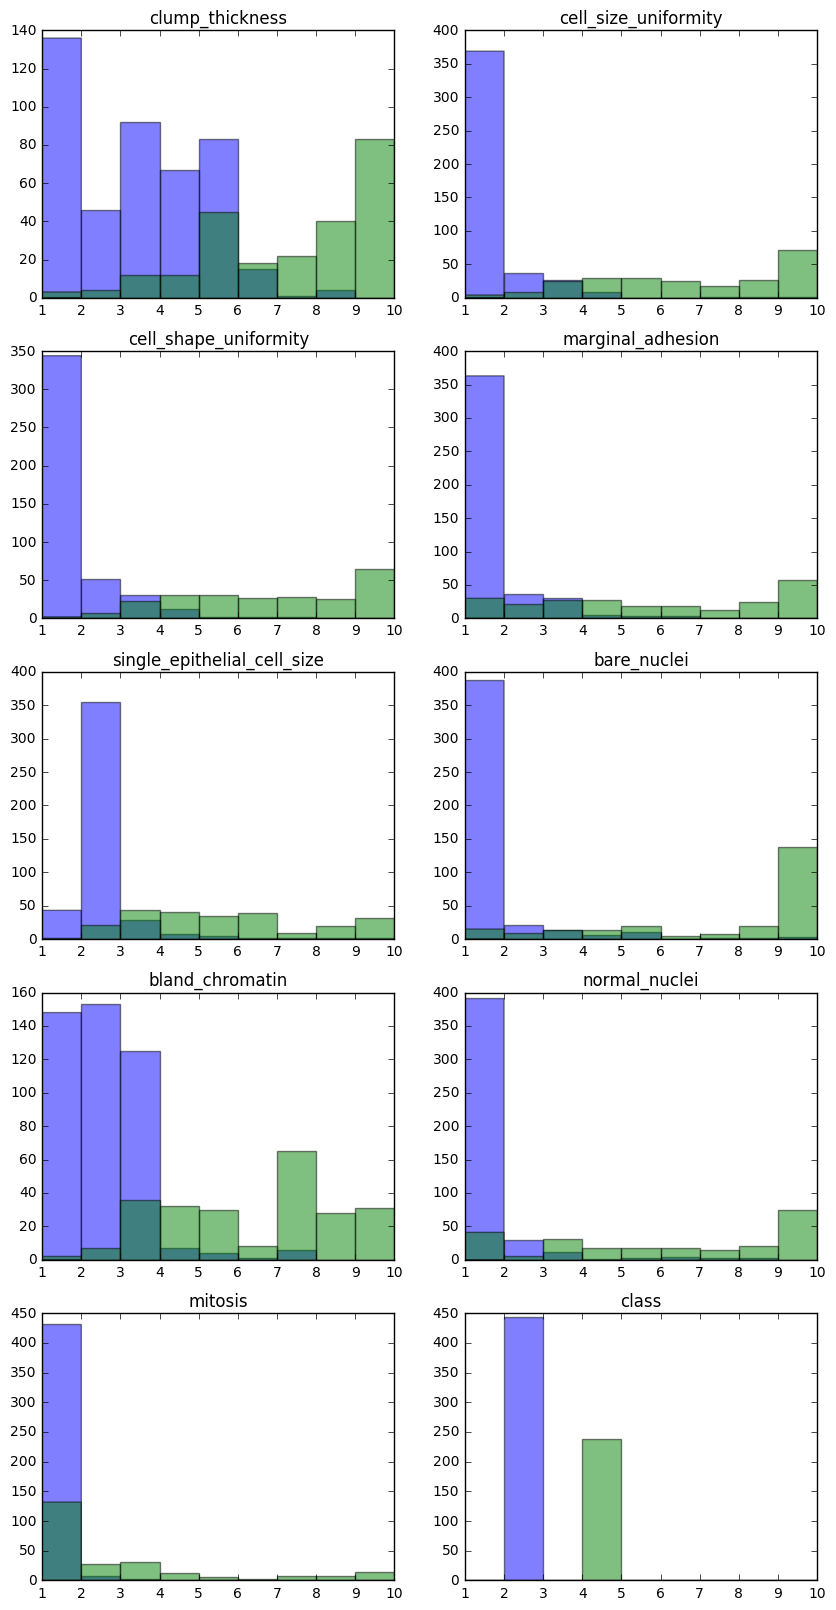

In [6]:
fig = plt.figure(figsize=(10,20))

col_names = list(biopsy_results)

for i in range(5):
    for j in range(2):
        ax = plt.subplot2grid((5,2),(i,j))
        _ = ax.hist(benign_df[col_names[2*i+j]]
                    [~np.isnan(benign_df[col_names[2*i+j]])],
                    alpha=0.5, bins=[1,2,3,4,5,6,7,8,9,10])
        _ = ax.hist(malignant_df[col_names[2*i+j]]
                    [~np.isnan(malignant_df[col_names[2*i+j]])],
                    alpha=0.5, bins=[1,2,3,4,5,6,7,8,9,10])
        ax.title.set_text(col_names[2*i+j])

None of the features are perfect predictors of the output class, so we turn to a classifier. Also, while the classes are unbalanced, they are not egregiously so, so for the first pass we will not balance the training data.

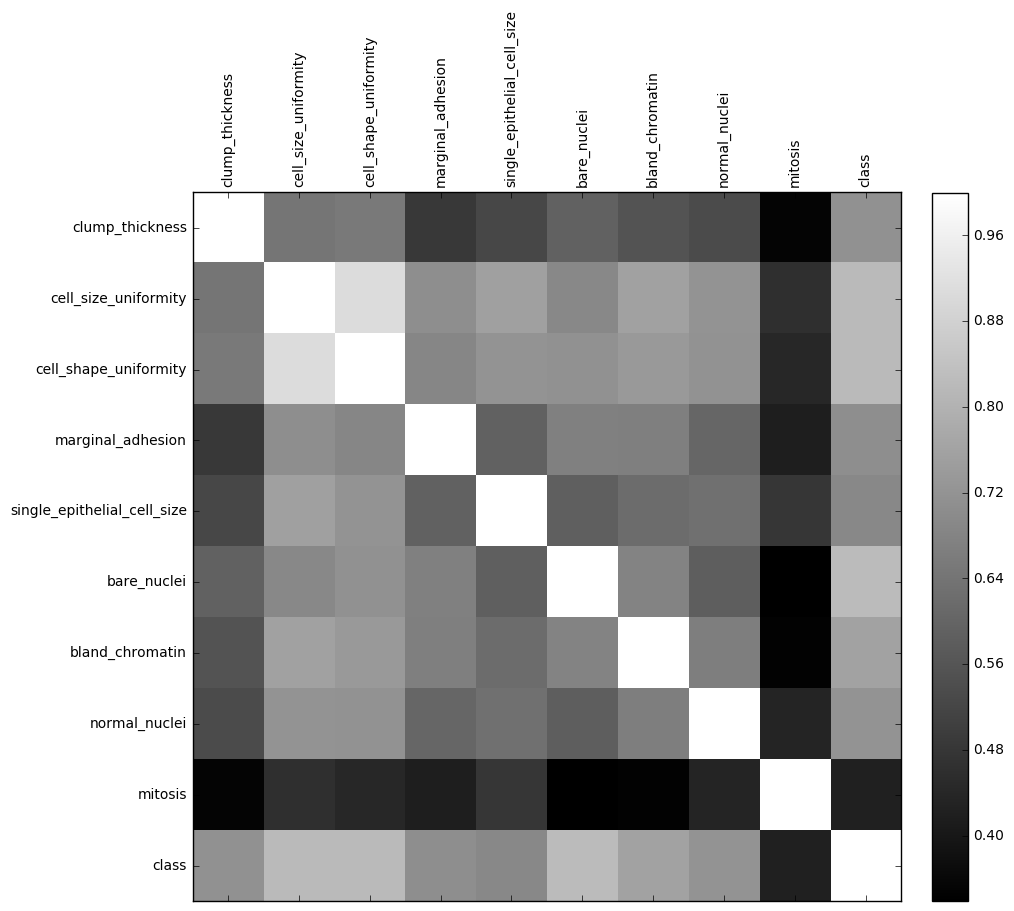

In [7]:
# Examine correlations between features

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(biopsy_results.corr(),cmap='gray')
plt.xticks(range(len(list(biopsy_results))),list(biopsy_results),
           rotation=90)
plt.yticks(range(len(list(biopsy_results))),list(biopsy_results))
fig.colorbar(cax, fraction=0.0457, pad=0.04);

Here we see that there are strong correlations between many of the features, so we will need to be careful about how we "rank" feature importance. Note that the uniformity of cell size and shape, and the bare nuclei, appear to be strongly correlated with the final class, so we might expect them to be "important". However, these features are also strongly correlated with many of the other features, so their importance may simply be a reflection of the fact that they carry information from all features. This is especially true of size and shape uniformity, which are strongly correlated with each other.

# Construct Random Forest Classifier

In [8]:
# Isolate features and output target class

features = [f for f in biopsy_results.columns.tolist() 
            if f not in ['class']]
target = 'class'

In [9]:
# Split into training and test sets

from sklearn.model_selection import train_test_split,cross_val_score

train_set =( 
    biopsy_results.sample(frac=0.7, random_state=3) )
test_set =( 
    biopsy_results.loc[~biopsy_results.index.isin(train_set.index)] )

In [10]:
# Initialize Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 4000)

In [11]:
# Perform 5-fold cross validation to estimate performance of the model

score_acc =( 
    cross_val_score(model,train_set[features],
                (np.array(train_set[target].tolist())/2-1).astype(int),
                cv=5,scoring='accuracy') )
print("Accuracy: %0.2f (+/- %0.2f)" 
      % (score_acc.mean(), score_acc.std() * 2))

score_pre =( 
    cross_val_score(model,train_set[features],
                (np.array(train_set[target].tolist())/2-1).astype(int),
                cv=5,scoring='precision') )
print("Precision: %0.2f (+/- %0.2f)" 
      % (score_pre.mean(), score_pre.std() * 2))

score_rec =( 
    cross_val_score(model,train_set[features],
                (np.array(train_set[target].tolist())/2-1).astype(int),
                cv=5,scoring='recall') )
print("Recall: %0.2f (+/- %0.2f)" 
      % (score_rec.mean(), score_rec.std() * 2))

score_f1 =( 
    cross_val_score(model,train_set[features],
                (np.array(train_set[target].tolist())/2-1).astype(int),
                cv=5,scoring='f1') )
print("F1 Score: %0.2f (+/- %0.2f)" 
      % (score_f1.mean(), score_f1.std() * 2))


Accuracy: 0.97 (+/- 0.05)
Precision: 0.95 (+/- 0.06)
Recall: 0.96 (+/- 0.12)
F1 Score: 0.95 (+/- 0.07)


We see that accuracy, precision, and recall are all very high (>95%). However, the uncertainty on recall is also high, meaning there is a good chance that this model will miss a significant amount of actually malignant results. One way to reduce this possibility is to adjust the decision threshold of the model, so that more samples are classified as malignant, at the expense of reducing accuracy by increasing the false positive rate. In the case of identifying malignant tumors, it is likely that having as near perfect recall (no false negatives) as possible is desirable, as long as it does not egregiously introduce false positives. To see this in action, we retrain the model on the entire training set, then examine the relationship between the false negative rate, the false positive rate, and the decision threshold in its performance on the test set.

In [12]:
# Fit the classifier to the training set

model.fit(train_set[features], train_set[target])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=4000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [13]:
# Predict probabilities of classes on the test set

predictions = model.predict_proba(test_set[features])

In [14]:
# Examine the performance of the model as a function 
# of decision threshold
# First, recast classes 2->benign,4->malignant 
# into 0->benign,1->malignant

true_class = (np.array(test_set[target].tolist())/2-1).astype(int)

In [15]:
# Create a threshold table that shows the prediction 
# of the model at different probability decision thresholds 
# (model default is 0.5)

threshold_table =( 
    pd.DataFrame({'probability_cancer': pd.Series(predictions[:,1]),
                  'true_class': pd.Series(true_class)}) )

In [16]:
# Add all the different threshold columns to the threshold table 
# with increments of 0.01

for thresh in np.linspace(0.3,1.0,num=71):
    threshold_table[str(thresh)] = predictions[:,1] >= thresh
    threshold_table[str(thresh)] =( 
                        threshold_table[str(thresh)].astype(int) )

In [17]:
# Calculate the false positive and false negative rates 
# for each threshold


fp_rate = []
fn_rate = []

for thresh in np.linspace(0.3,1.0,num=71):
    thresh_col_name = str(thresh)
    # At each threshold, calculate the number of correctly 
    # classified benign tests
    tn = len(threshold_table.loc[(threshold_table['true_class']==0) 
                                 & (threshold_table[str(thresh)]==0)])
    # the number of falsely classified malignant tests
    fp = len(threshold_table.loc[(threshold_table['true_class']==0) 
                                 & (threshold_table[str(thresh)]==1)])
    # the number of falsely classified benign tests
    fn = len(threshold_table.loc[(threshold_table['true_class']==1) 
                                 & (threshold_table[str(thresh)]==0)])
    # and the number of correctly classified malignant tests
    tp = len(threshold_table.loc[(threshold_table['true_class']==1) 
                                 & (threshold_table[str(thresh)]==1)])
    
    # The False Positive Rate is the rate at which actual benign
    # tests are classified as malignant
    fp_rate.append(fp/(fp+tn))
    # The False Negative Rate is the rate at which actual malignant
    # tests are classified as benign
    fn_rate.append(fn/(fn+tp))

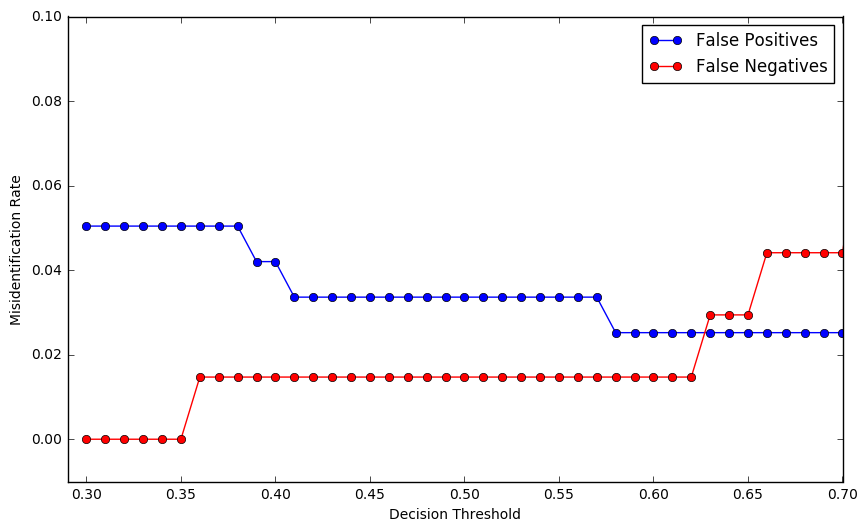

In [18]:
# Plot the relationship between threshold and 
# the misidentification rates

fig = plt.figure(figsize=(10,6))
plt.plot(np.linspace(0.3,1.0,num=71),fp_rate,'-ob')
plt.plot(np.linspace(0.3,1.0,num=71),fn_rate,'-or')
plt.xlim([0.29,0.7])
plt.ylim([-0.01,0.1])
plt.xlabel('Decision Threshold')
plt.ylabel('Misidentification Rate')
plt.legend(['False Positives','False Negatives']);

Note that this relationship holds only for this held out test set. Claiming that reducing the decision threshold to 0.37 results in perfect recall risks over-interpreting the results of this single test. In general, reducing the decision threshold will result in a lower false negative rate with a corresponding increase in the false positive rate, and we can say that to achieve optimal results (no false negatives) we need to reduce the decision threshold from the default of 0.5 down to somewhere around 0.35, and that the false positive rate will increase a few percentage points. Repeating this test on multiple hold out sets from a larger sample would allow for better estimates of exactly how the decision threshold impacts misidentification rates.

# Ranking Feature Importance

In [19]:
# Sort the features based on "gini" importance score

sorted_features =(
         sorted(list(zip(features,model.feature_importances_)), 
                         key = lambda tup: tup[1]) )

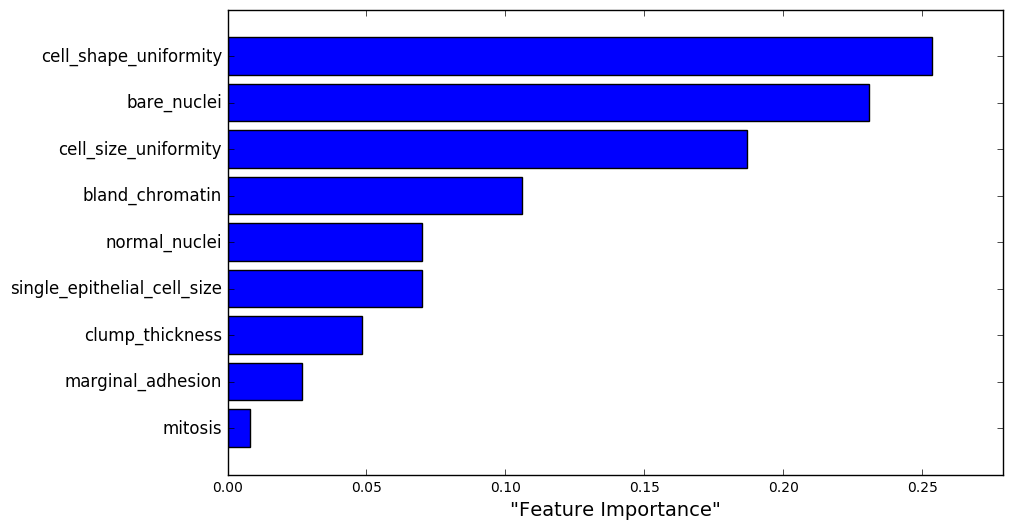

In [20]:
ind = np.arange(len(features))
fig = plt.figure(figsize=(10,6))
plt.barh(ind,list(zip(*sorted_features))[1], align='center')
plt.yticks(ind,list(zip(*sorted_features))[0],fontsize=12)
plt.xlabel('"Feature Importance"',fontsize=14)
plt.xlim([0,1.1*np.max(model.feature_importances_)]);

# Summary

The model as constructed returns predictions for the class of a biopsy with 97% accuracy and a false negative rate of ~5%. The decision threshold for the model can be tuned to reduce the false negative rate, but only with a corresponding increase in the false positive rate. Exactly how this trade-off should be made requires knowledge of the costs and risks associated with false negatives and positives. Further steps that could be taken to improve the accuracy of the model include balancing the dataset so that the all-important malignant entries are not underrepresented in the sample, and hyperparameter tuning of the random forest class. However, both of these approaches risk over-reliance of the interpretation of the results on a relatively small dataset. The real best next step is to obtain a much larger set of biopsy results to train on....

In examining the ranked feature importances, we see, as expected from the correlation analysis earlier, that the most "important" features are cell size and shape uniformity, and the bare nuclei. Again, this must be taken cautiously since the feature set is highly intercorrelated.

While this classifier is by no means "production ready", this small project did highlight some of the opportunities and challenges facing the future of machine learning in the medical field. Perhaps most importantly, this project shows the importance of defining the correct metrics for "success". I had to address the imperfect recall by tuning the decision threshold and lowering overall accuracy. This was a heuristic approach to balancing the accuracy of the classification with my intuition about the relative importance of different results. In a very (very, very...) small way, this mimics the problem the Watson project faced - as good as the technology may be, defining the goals of the project and evaluating success is still a very human part of the process.

#### This jupyter notebook and the data file 'biopsy_results.csv' are available at:

github.com/itay-rosenzweig/tumor_biopsy
